In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/surface-crack/valid/Negative/IMG_2626_8_8.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_0293_4_10.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_2979_8_7.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_2511_4_13.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_9627_8_9.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_0254_7_8.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_2977_3_3.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_0254_9_6.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_2016_1_11.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_2010_2_8.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_1424_5_16.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_2979_8_8.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_0472_10_10.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_0471_3_5.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_2015_11_3.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_2626_8_7.jpg
/kaggle/input/surface-crack/valid

# Importing necessary Libraries

In [2]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import tensorflow as tf
import os
from PIL import Image
import random
from matplotlib import pyplot as plt
import numpy as np
from keras import Sequential
from tensorflow.keras import optimizers
from keras.layers import Dense, Dropout
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow_addons as tfa

# Importing the transfer model
### We are going to use the pretrained model named VGG16

In [3]:
transfer_model = VGG16()
transfer_model.summary()

2023-01-16 17:07:24.134146: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 17:07:24.209865: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 17:07:24.210712: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 17:07:24.211890: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

553476096/553467096 [==============================] - 24s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

# Retrieve the data and augment it for more training data

### Copying the dataset to working directory

In [4]:
! rm -rf "/kaggle/working/surface-crack" 
! cp -rf "/kaggle/input/surface-crack" "/kaggle/working/surface-crack"

In [5]:
DIR = "/kaggle/working/surface-crack/"
train_dir = os.path.join(DIR, 'train/')
print("Training Data: Positive: ", len(os.listdir(os.path.join(train_dir, 'Positive'))), "Negative: ", len(os.listdir(os.path.join(train_dir, 'Negative'))))
val_dir = os.path.join(DIR, 'valid/')
print("Validating Data: Positive: ", len(os.listdir(os.path.join(val_dir, 'Positive'))), "Negative: ", len(os.listdir(os.path.join(val_dir, 'Negative'))))
test_dir = os.path.join(DIR, 'test/')
print("Testing Data: Positive: ", len(os.listdir(os.path.join(test_dir, 'Positive'))), "Negative: ", len(os.listdir(os.path.join(test_dir, 'Negative'))))
# len(os.listdir(os.path.join(DIR, 'valid/', 'Positive')))

Training Data: Positive:  300 Negative:  300
Validating Data: Positive:  100 Negative:  100
Testing Data: Positive:  100 Negative:  100


### Display the data

Crack Shape: (224, 224) 
No Crack Shape: (224, 224)


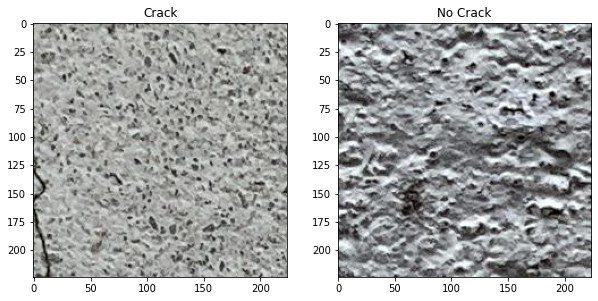

In [6]:
index_pos = random.randint(0,len(os.listdir(os.path.join(train_dir, 'Positive'))))
index_neg = random.randint(0,len(os.listdir(os.path.join(train_dir, 'Negative'))))
sample_crack = Image.open(os.path.join(train_dir, 
                                       'Positive/', 
                                       os.listdir(os.path.join(train_dir, 'Positive/'))[index_pos]))
sample_no_crack = Image.open(os.path.join(train_dir, 
                                       'Negative/', 
                                       os.listdir(os.path.join(train_dir, 'Negative/'))[index_neg]))
print("Crack Shape:",sample_crack.size, "\nNo Crack Shape:",sample_no_crack.size)
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.imshow(sample_crack)
plt.title("Crack")
plt.subplot(1,2,2)
plt.imshow(sample_no_crack)
plt.title("No Crack")
plt.show()

In [7]:
# A function for visualizing the augmentation
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)
    flipped = tf.image.flip_left_right(image)
    visualize(image, flipped)

### Display the augmented data

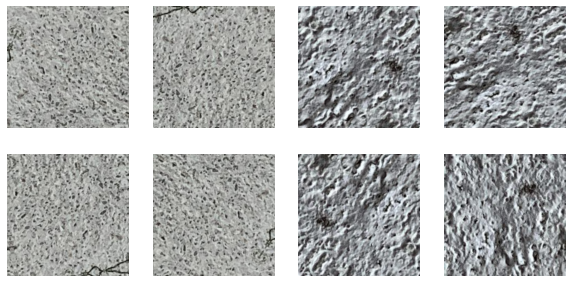

In [8]:
data_augmentation = tf.keras.Sequential([
     tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
     tf.keras.layers.experimental.preprocessing.RandomRotation(0.9)])

image_crack = tf.expand_dims(sample_crack, 0)
image_no_crack = tf.expand_dims(sample_no_crack, 0)
plt.figure(figsize=(10,5))

for i in range(4):
    augmented_crack_image = data_augmentation(image_crack)
    augmented_no_crack_image = data_augmentation(image_no_crack)
    if(i < 2):
        plt.subplot(2, 4, i+1)
        plt.imshow(augmented_crack_image[0])
        plt.axis('off')
        plt.subplot(2,4,i+3)
        plt.imshow(augmented_no_crack_image[0])
        plt.axis("off")
    else:
        plt.subplot(2, 4, i+3)
        plt.imshow(augmented_crack_image[0])
        plt.axis('off')
        plt.subplot(2,4,i+5)
        plt.imshow(augmented_no_crack_image[0])
        plt.axis("off")

### Augment the data over all data in training set

In [9]:
def augment(image_to_augment, times):
    result = []
    image = tf.expand_dims(image_to_augment, 0)
    for i in range(times):
        augmented_image = data_augmentation(image)
        result.append(augmented_image[0])
    return result

#### Augmenting Training Data

In [10]:
pos_loc = os.path.join(train_dir,'Positive/')
neg_loc = os.path.join(train_dir, 'Negative/')
for i, image in enumerate(os.listdir(pos_loc)):
    image_file = Image.open(os.path.join(pos_loc,image))
    aug_res = augment(image_file, 4)
    for j, aug_img in enumerate(aug_res):
        aug_image = np.array(aug_img)
        aug_image = Image.fromarray(aug_image)
        save_loc = pos_loc+image[0:-4]+"_aug_"+str(j)+".jpg"
        aug_image.save(save_loc)
        print("Progress:",(i*(j+1)*100)/len(os.listdir(pos_loc)), end = '\r')

for i, image in enumerate(os.listdir(neg_loc)):
    image_file = Image.open(os.path.join(neg_loc,image))
    aug_res = augment(image_file, 4)
    for j, aug_img in enumerate(aug_res):
        aug_image = np.array(aug_img)
        aug_image = Image.fromarray(aug_image)
        save_loc = neg_loc+image[0:-4]+"_aug_"+str(j)+".jpg"
        aug_image.save(save_loc)
        print("Progress:",(i*(j+1)*100)/len(os.listdir(neg_loc)), end = '\r')


#### Augmenting Validation Data

In [11]:
pos_loc = os.path.join(val_dir,'Positive/')
neg_loc = os.path.join(val_dir, 'Negative/')
for i, image in enumerate(os.listdir(pos_loc)):
    image_file = Image.open(os.path.join(pos_loc,image))
    aug_res = augment(image_file, 3)
    for j, aug_img in enumerate(aug_res):
        aug_image = np.array(aug_img)
        aug_image = Image.fromarray(aug_image)
        save_loc = pos_loc+image[0:-4]+"_aug_"+str(j)+".jpg"
        aug_image.save(save_loc)
        print("Progress(Positive):",(i*(j+1)*100)/len(os.listdir(pos_loc)), end = '\r')

for i, image in enumerate(os.listdir(neg_loc)):
    image_file = Image.open(os.path.join(neg_loc,image))
    aug_res = augment(image_file, 3)
    for j, aug_img in enumerate(aug_res):
        aug_image = np.array(aug_img)
        aug_image = Image.fromarray(aug_image)
        save_loc = neg_loc+image[0:-4]+"_aug_"+str(j)+".jpg"
        aug_image.save(save_loc)
        print("Progress(Negative):",(i*(j+1)*100)/len(os.listdir(neg_loc)), end = '\r')

In [12]:
DIR = "/kaggle/working/surface-crack/"
train_dir = os.path.join(DIR, 'train/')
print("Training Data: Positive: ", len(os.listdir(os.path.join(train_dir, 'Positive'))), "Negative: ", len(os.listdir(os.path.join(train_dir, 'Negative'))))
val_dir = os.path.join(DIR, 'valid/')
print("Validating Data: Positive: ", len(os.listdir(os.path.join(val_dir, 'Positive'))), "Negative: ", len(os.listdir(os.path.join(val_dir, 'Negative'))))
test_dir = os.path.join(DIR, 'test/')
print("Testing Data: Positive: ", len(os.listdir(os.path.join(test_dir, 'Positive'))), "Negative: ", len(os.listdir(os.path.join(test_dir, 'Negative'))))

Training Data: Positive:  1500 Negative:  1500
Validating Data: Positive:  400 Negative:  400
Testing Data: Positive:  100 Negative:  100


### Apply VGG16 Preprocessing over train and test data

In [13]:
! rm -rf "/kaggle/working/DATASET/"
! mkdir "/kaggle/working/DATASET/"
! mkdir "/kaggle/working/DATASET/train/"
! mkdir "/kaggle/working/DATASET/train/Positive/"
! mkdir "/kaggle/working/DATASET/train/Negative/"
! mkdir "/kaggle/working/DATASET/valid/"
! mkdir "/kaggle/working/DATASET/valid/Positive/"
! mkdir "/kaggle/working/DATASET/valid/Negative/"

In [14]:

train_pos_loc = os.path.join(train_dir,'Positive/')
train_neg_loc = os.path.join(train_dir, 'Negative/')
val_pos_loc = os.path.join(val_dir,'Positive/')
val_neg_loc = os.path.join(val_dir, 'Negative/')
test_pos_loc = os.path.join(test_dir,'Positive/')
test_neg_loc = os.path.join(test_dir, 'Negative/')
for i, image in enumerate(os.listdir(train_pos_loc)):
    image_file = Image.open(os.path.join(train_pos_loc,image))
    save_image = np.asarray(image_file)
    save_image = preprocess_input(save_image)
    save_loc = "/kaggle/working/DATASET/train/Positive/"+image
    np.save(save_loc, save_image)
    print("Progress(Training - Positive):",(i*100)/len(os.listdir(train_pos_loc)), end = '\r')

for i, image in enumerate(os.listdir(train_neg_loc)):
    image_file = Image.open(os.path.join(train_neg_loc,image))
    save_image = np.asarray(image_file)
    save_image = preprocess_input(save_image)
    save_loc = "/kaggle/working/DATASET/train/Negative/"+image
    np.save(save_loc, save_image)
    print("Progress(Training - Negative):",(i*100)/len(os.listdir(train_neg_loc)), end = '\r')

for i, image in enumerate(os.listdir(val_pos_loc)):
    image_file = Image.open(os.path.join(val_pos_loc,image))
    save_image = np.asarray(image_file)
    save_image = preprocess_input(save_image)
    save_loc = "/kaggle/working/DATASET/valid/Positive/"+image
    np.save(save_loc, save_image)
    print("Progress(Validation - Positive):",(i*100)/len(os.listdir(val_pos_loc)), end = '\r')

for i, image in enumerate(os.listdir(val_neg_loc)):
    image_file = Image.open(os.path.join(val_neg_loc,image))
    save_image = np.asarray(image_file)
    save_image = preprocess_input(save_image)
    save_loc = "/kaggle/working/DATASET/valid/Negative/"+image
    np.save(save_loc, save_image)
    print("Progress(Validation - Negative):",(i*100)/len(os.listdir(val_neg_loc)), end = '\r')    

In [15]:
DIR = "/kaggle/working/DATASET/"
train_dir = os.path.join(DIR, 'train/')
print("Training Data: Positive: ", len(os.listdir(os.path.join(train_dir, 'Positive'))), "Negative: ", len(os.listdir(os.path.join(train_dir, 'Negative'))))
val_dir = os.path.join(DIR, 'valid/')
print("Validating Data: Positive: ", len(os.listdir(os.path.join(val_dir, 'Positive'))), "Negative: ", len(os.listdir(os.path.join(val_dir, 'Negative'))))
# test_dir = os.path.join(DIR, 'test/')
# print("Testing Data: Positive: ", len(os.listdir(os.path.join(test_dir, 'Positive'))), "Negative: ", len(os.listdir(os.path.join(test_dir, 'Negative'))))

Training Data: Positive:  1500 Negative:  1500
Validating Data: Positive:  400 Negative:  400


# Setting up the dataset

In [16]:
X_train = []
y_train = []

for arr in os.listdir(os.path.join(train_dir, "Positive/")):
    X_train.append(np.load(os.path.join(train_dir, "Positive/",arr)))
    y_train.append(0)
for arr in os.listdir(os.path.join(train_dir, "Negative/")):
    X_train.append(np.load(os.path.join(train_dir, "Negative/",arr)))
    y_train.append(1)
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_val = []
y_val = []

for arr in os.listdir(os.path.join(val_dir, "Positive/")):
    X_val.append(np.load(os.path.join(val_dir, "Positive/",arr)))
    y_val.append(0)
for arr in os.listdir(os.path.join(val_dir, "Negative/")):
    X_val.append(np.load(os.path.join(val_dir, "Negative/",arr)))
    y_val.append(1)
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((3000, 224, 224, 3), (3000,), (800, 224, 224, 3), (800,))

In [17]:
# def shuffle_along_axis(a, axis):
#     idx = np.random.rand(*a.shape).argsort(axis=axis)
#     return np.take_along_axis(a,idx,axis=axis)
# X_train = shuffle_along_axis(X_train, 3)
# y_train = shuffle_along_axis(y_train, 0)
# X_val = shuffle_along_axis(X_val, 3)
# y_val = shuffle_along_axis(y_val, 0)

1


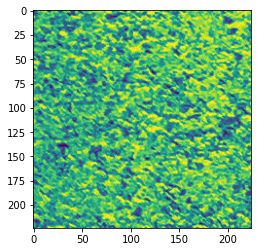

In [18]:
index = random.randint(0, 3000)
sample_crack = X_train[index, :, :, 0]
sample_label = y_train[index]
print(sample_label)
plt.imshow(sample_crack)

0


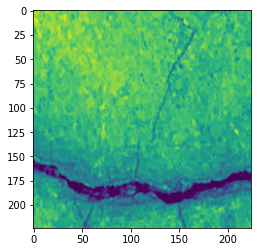

In [19]:
index = random.randint(0, 200)
sample_crack = X_val[index, :, :, 0]
sample_label = y_val[index]
print(sample_label)
plt.imshow(sample_crack)

# Creating the model

In [20]:
model = Sequential()
for i, layer in enumerate(transfer_model.layers):
    if i < 20:
        model.add(layer)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [21]:
for layer in model.layers:
    layer.trainable = False
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [22]:
model.add(Dense(112, activation = 'relu'))
model.add(Dense(12, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [24]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)
model.compile(optimizer=optimizer,
             loss = tf.keras.losses.BinaryCrossentropy(),
             metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [25]:
history = model.fit(X_train, y_train, batch_size = 32, epochs = 50, verbose = 1, validation_data = (X_val, y_val))

2023-01-16 17:09:30.335785: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1806336000 exceeds 10% of free system memory.
2023-01-16 17:09:33.138787: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1806336000 exceeds 10% of free system memory.
2023-01-16 17:09:34.730310: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2023-01-16 17:09:36.593504: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


94/94 [==============================] - 22s 127ms/step - loss: 0.9476 - accuracy: 0.5463 - precision: 0.5935 - recall: 0.2940 - val_loss: 0.7252 - val_accuracy: 0.6237 - val_precision: 0.6840 - val_recall: 0.4600
Epoch 2/50
94/94 [==============================] - 8s 85ms/step - loss: 0.6546 - accuracy: 0.6517 - precision: 0.6816 - recall: 0.5693 - val_loss: 0.5795 - val_accuracy: 0.7150 - val_precision: 0.7544 - val_recall: 0.6375
Epoch 3/50
94/94 [==============================] - 8s 85ms/step - loss: 0.5426 - accuracy: 0.7297 - precision: 0.7445 - recall: 0.6993 - val_loss: 0.4960 - val_accuracy: 0.7725 - val_precision: 0.8079 - val_recall: 0.7150
Epoch 4/50
94/94 [==============================] - 8s 85ms/step - loss: 0.4661 - accuracy: 0.7893 - precision: 0.7952 - recall: 0.7793 - val_loss: 0.4359 - val_accuracy: 0.8112 - val_precision: 0.8449 - val_recall: 0.7625
Epoch 5/50
94/94 [==============================] - 8s 85ms/step - loss: 0.4059 - accuracy: 0.8270 - precision: 0.823

In [26]:
model.save("Model3.h5")

In [27]:
hd = history.history
hd.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

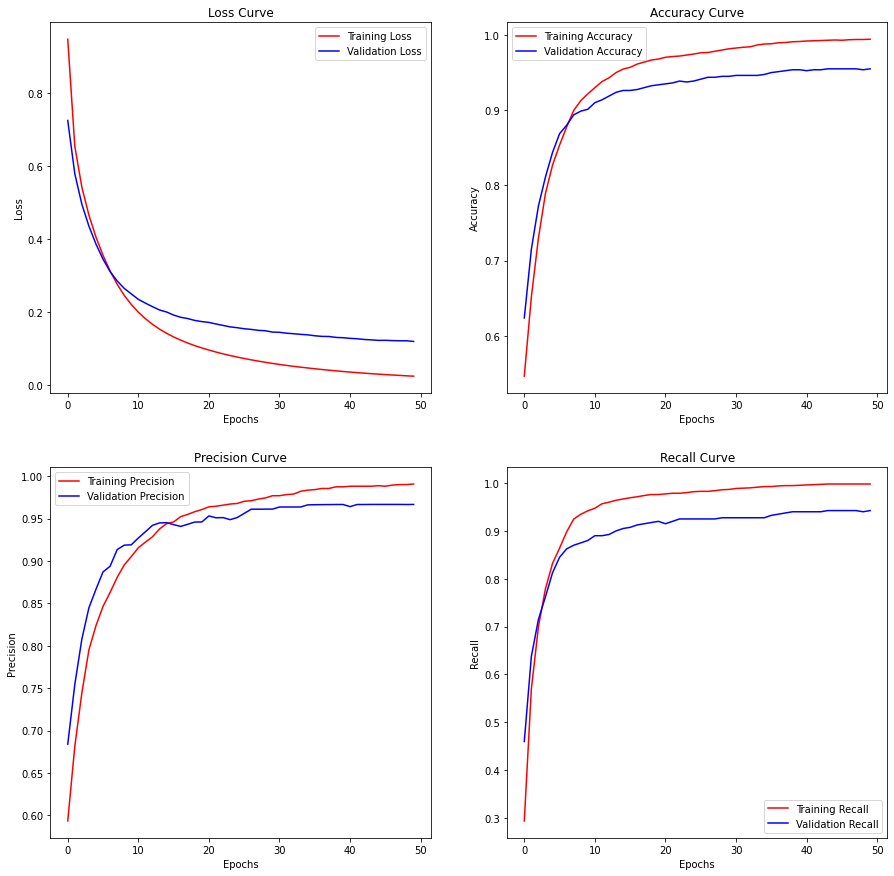

In [28]:
plt.figure(figsize = (15,15))

plt.subplot(2,2,1)
plt.plot(hd['loss'], c = 'red', label = 'Training Loss')
plt.plot(hd['val_loss'], c = 'blue', label = "Validation Loss")
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(2,2,2)
plt.plot(hd['accuracy'], c = 'red', label = 'Training Accuracy')
plt.plot(hd['val_accuracy'], c = 'blue', label = "Validation Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(2,2,3)
plt.plot(hd['precision'], c = 'red', label = 'Training Precision')
plt.plot(hd['val_precision'], c = 'blue', label = "Validation Precision")
plt.title("Precision Curve")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend()

plt.subplot(2,2,4)
plt.plot(hd['recall'], c = 'red', label = 'Training Recall')
plt.plot(hd['val_recall'], c = 'blue', label = "Validation Recall")
plt.title("Recall Curve")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend()
plt.show()

In [30]:
precision = np.asarray(hd['precision'])
val_precision = np.asarray(hd['val_precision'])
recall = np.asarray(hd['recall'])
val_recall = np.asarray(hd['val_recall'])
f1Score = (2*precision*recall)/(precision+recall)
val_f1Score = (2*val_precision*val_recall)/(val_precision+val_recall)
print("Final F1 Score: \nTraining:",f1Score[-1],"\nValidation:",val_f1Score[-1])

Final F1 Score: 
Training: 0.9943540600448029 
Validation: 0.9544303637440245


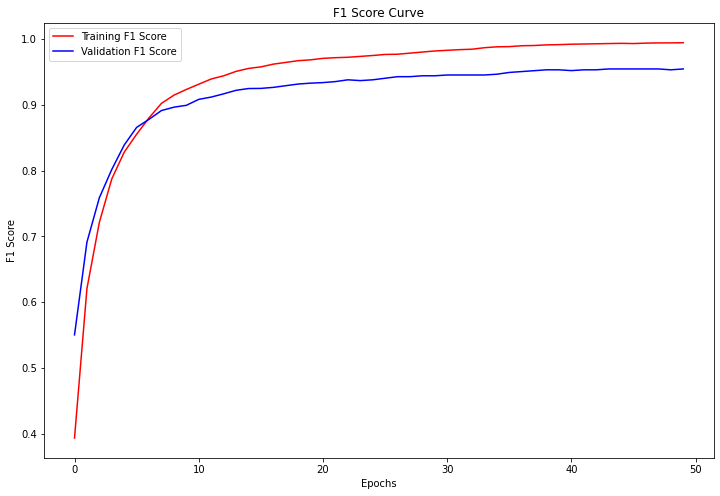

In [31]:
plt.figure(figsize = (12,8))
plt.plot(f1Score, c = 'red', label = 'Training F1 Score')
plt.plot(val_f1Score, c = 'blue', label = "Validation F1 Score")
plt.title("F1 Score Curve")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend()
plt.show()

# Setting up the test data for testing the model

In [32]:
DIR = "/kaggle/working/surface-crack/"
test_dir = os.path.join(DIR, 'test/')
print("Testing Data: Positive: ", len(os.listdir(os.path.join(test_dir, 'Positive'))), "Negative: ", len(os.listdir(os.path.join(test_dir, 'Negative'))))

Testing Data: Positive:  100 Negative:  100


In [33]:
! mkdir "/kaggle/working/DATASET/test/"
! mkdir "/kaggle/working/DATASET/test/Positive/"
! mkdir "/kaggle/working/DATASET/test/Negative/"

In [34]:
test_pos_loc = os.path.join(test_dir,'Positive/')
test_neg_loc = os.path.join(test_dir, 'Negative/')
for i, image in enumerate(os.listdir(test_pos_loc)):
    image_file = Image.open(os.path.join(test_pos_loc,image))
    save_image = np.asarray(image_file)
    save_image = preprocess_input(save_image)
    save_loc = "/kaggle/working/DATASET/test/Positive/"+image
    np.save(save_loc, save_image)
    print("Progress(Testing - Positive):",(i*100)/len(os.listdir(test_pos_loc)), end = '\r')

for i, image in enumerate(os.listdir(test_neg_loc)):
    image_file = Image.open(os.path.join(test_neg_loc,image))
    save_image = np.asarray(image_file)
    save_image = preprocess_input(save_image)
    save_loc = "/kaggle/working/DATASET/test/Negative/"+image
    np.save(save_loc, save_image)
    print("Progress(Testing - Negative):",(i*100)/len(os.listdir(test_neg_loc)), end = '\r')

In [35]:
DIR = "/kaggle/working/DATASET/"
# train_dir = os.path.join(DIR, 'train/')
# print("Training Data: Positive: ", len(os.listdir(os.path.join(train_dir, 'Positive'))), "Negative: ", len(os.listdir(os.path.join(train_dir, 'Negative'))))
# val_dir = os.path.join(DIR, 'valid/')
# print("Validating Data: Positive: ", len(os.listdir(os.path.join(val_dir, 'Positive'))), "Negative: ", len(os.listdir(os.path.join(val_dir, 'Negative'))))
test_dir = os.path.join(DIR, 'test/')
print("Testing Data: Positive: ", len(os.listdir(os.path.join(test_dir, 'Positive'))), "Negative: ", len(os.listdir(os.path.join(test_dir, 'Negative'))))

Testing Data: Positive:  100 Negative:  100


In [40]:
X_test = []
y_test = []

for arr in os.listdir(os.path.join(test_dir, "Positive/")):
    X_test.append(np.load(os.path.join(test_dir, "Positive/",arr)))
    y_test.append(0)
for arr in os.listdir(os.path.join(test_dir, "Negative/")):
    X_test.append(np.load(os.path.join(test_dir, "Negative/",arr)))
    y_test.append(1)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [81]:
X_test.shape

(200, 224, 224, 3)

In [43]:
y_prob= model.predict(X_test)
y_prob.shape

(200, 1)

In [53]:
y_pred = np.round(y_prob)

In [64]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Model Test Accuracy: ", accuracy_score(y_pred, y_test)*100,"%")
print("Model Test Precision: ", precision_score(y_pred, y_test)*100,"%")
print("Model Test Recall: ", recall_score(y_pred, y_test)*100,"%")
print("Model Test F1 Score: ", f1_score(y_pred, y_test)*100,"%")

Model Test Accuracy:  93.5 %
Model Test Precision:  87.0 %
Model Test Recall:  100.0 %
Model Test F1 Score:  93.04812834224599 %


## For further analysis let's try to look at those images for which our model do not predict correctly
#### Upon analysis we have 13 images for which we get wrong results, let's see 12 of them

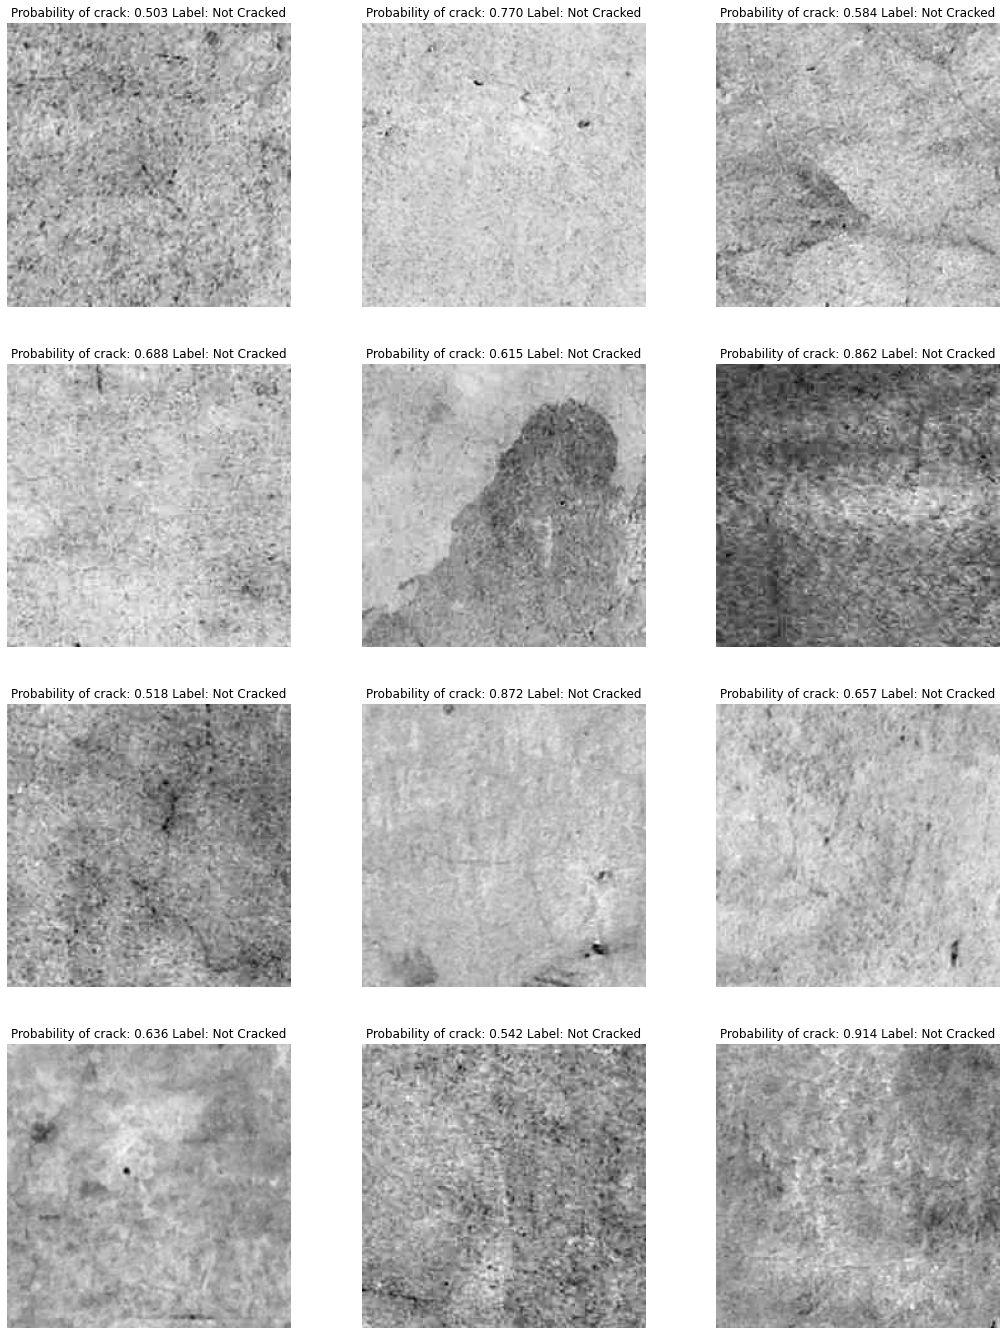

In [111]:
plt.figure(figsize = (18,24))

pltIndex = 1
for i in range(0,200):
    if(y_test[i] != y_pred[i,0]):
        plt.subplot(4,3,pltIndex)
        plt.imshow(X_test[i,:,:,1], cmap = 'gray')
        text = "Probability of crack: {0:.3f} Label: ".format(1-y_prob[i,0])+("Cracked" if y_test[i] == 0 else "Not Cracked")
        plt.title(text)
        plt.axis("off")
        pltIndex += 1
        if(pltIndex >= 13):
            break
plt.show()

### Inference:  We see that if we reduce the threshold for Crack upto 0.65 then the model will have a better accuracy, as it confuses slight shadows and nominal marks as promienent cracks.

### Let's set the boundary and see the metrics

In [112]:
y_pred = []
for value in y_prob:
    if(value < 0.35):
        y_pred.append(0)
    else:
        y_pred.append(1)
y_pred = np.asarray(y_pred)

In [113]:
print("Model Test Accuracy: ", accuracy_score(y_pred, y_test)*100,"%")
print("Model Test Precision: ", precision_score(y_pred, y_test)*100,"%")
print("Model Test Recall: ", recall_score(y_pred, y_test)*100,"%")
print("Model Test F1 Score: ", f1_score(y_pred, y_test)*100,"%")

Model Test Accuracy:  97.0 %
Model Test Precision:  94.0 %
Model Test Recall:  100.0 %
Model Test F1 Score:  96.90721649484536 %


### Hence, we see that we have comparatively better performance.

# Using the model to predict in a high resolution image, similar to object detection, (Crack Detection)

In [190]:
def predict(image):
    arr = np.expand_dims(image, 0)
    arr = preprocess_input(arr)
    prediction = model.predict(arr)
    if(prediction[0,0] < 0.35):
        return (0,prediction[0,0])
    else:
        return (1,prediction[0,0])

In [192]:
def bounding_box(img_arr):
    for i in range(0, img_arr.shape[0], 224):
        for j in range(0, img_arr.shape[1], 224):
            if(img_arr[i:i+224,j:j+224,:].shape == (224,224,3)):
                if(predict(img_arr[i:i+224,j:j+224,:])[0]==0):
                    a = i
                    b = j
                    for a in range(i, i+224):
                        img_arr[a,j,:] = np.array([0,0,0])
                        img_arr[a,j+223,:] = np.array([0,0,0])
                    for b in range(j, j+224):
                        img_arr[i,b,:] = np.array([0,0,0])
                        img_arr[i+223,b,:] = np.array([0,0,0])
    return img_arr
            

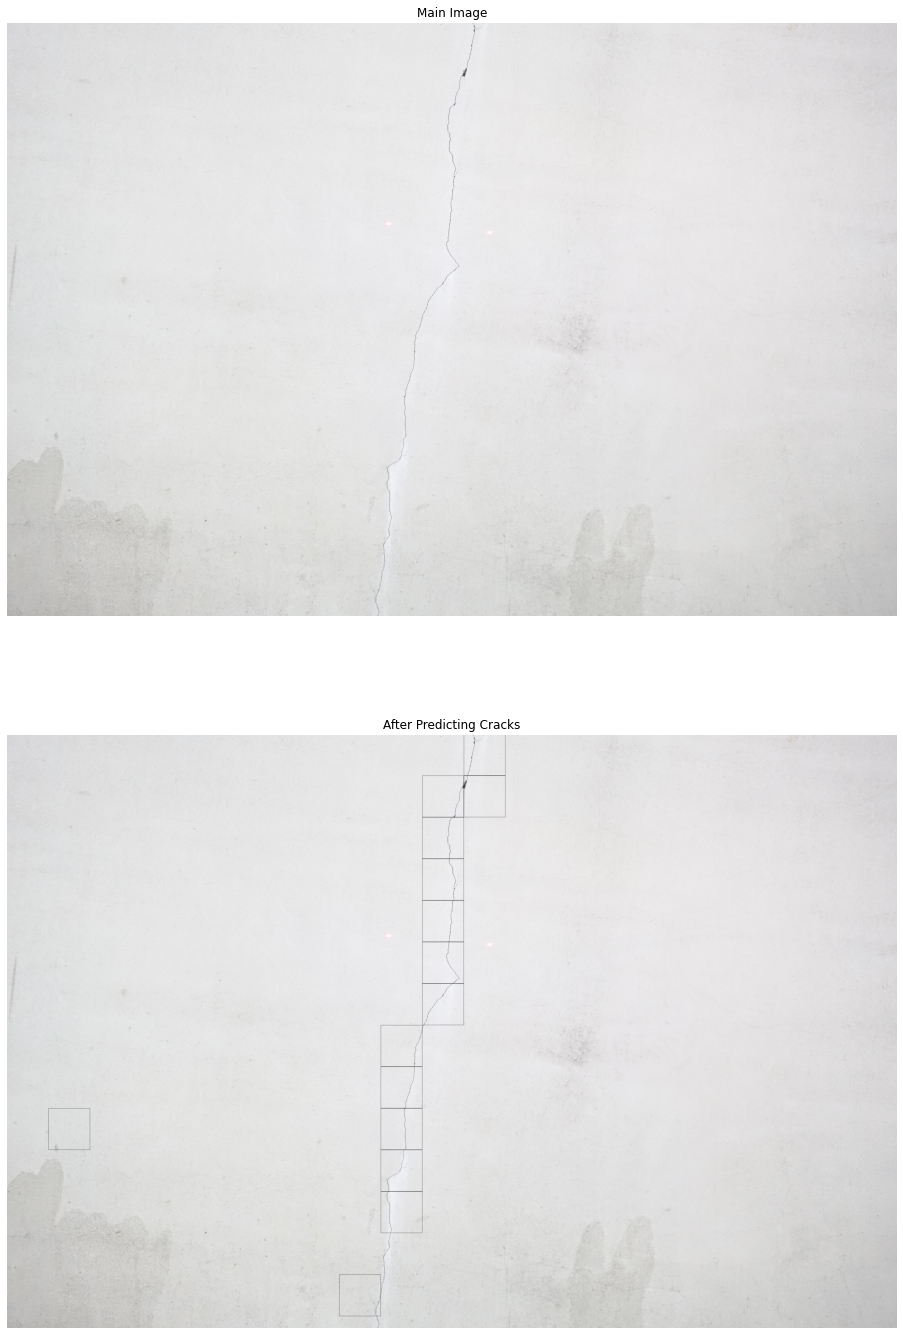

In [215]:
image = Image.open("/kaggle/input/surface-crack/predict/IMG_1129.JPG")
plt.figure(figsize = (32,24))
plt.subplot(2,1,1)
plt.imshow(image)
plt.title("Main Image")
plt.axis('off')

img_bound = bounding_box(np.asarray(image))

plt.subplot(2,1,2)
plt.imshow(img_bound)
plt.title("After Predicting Cracks")
plt.axis('off')

plt.show()

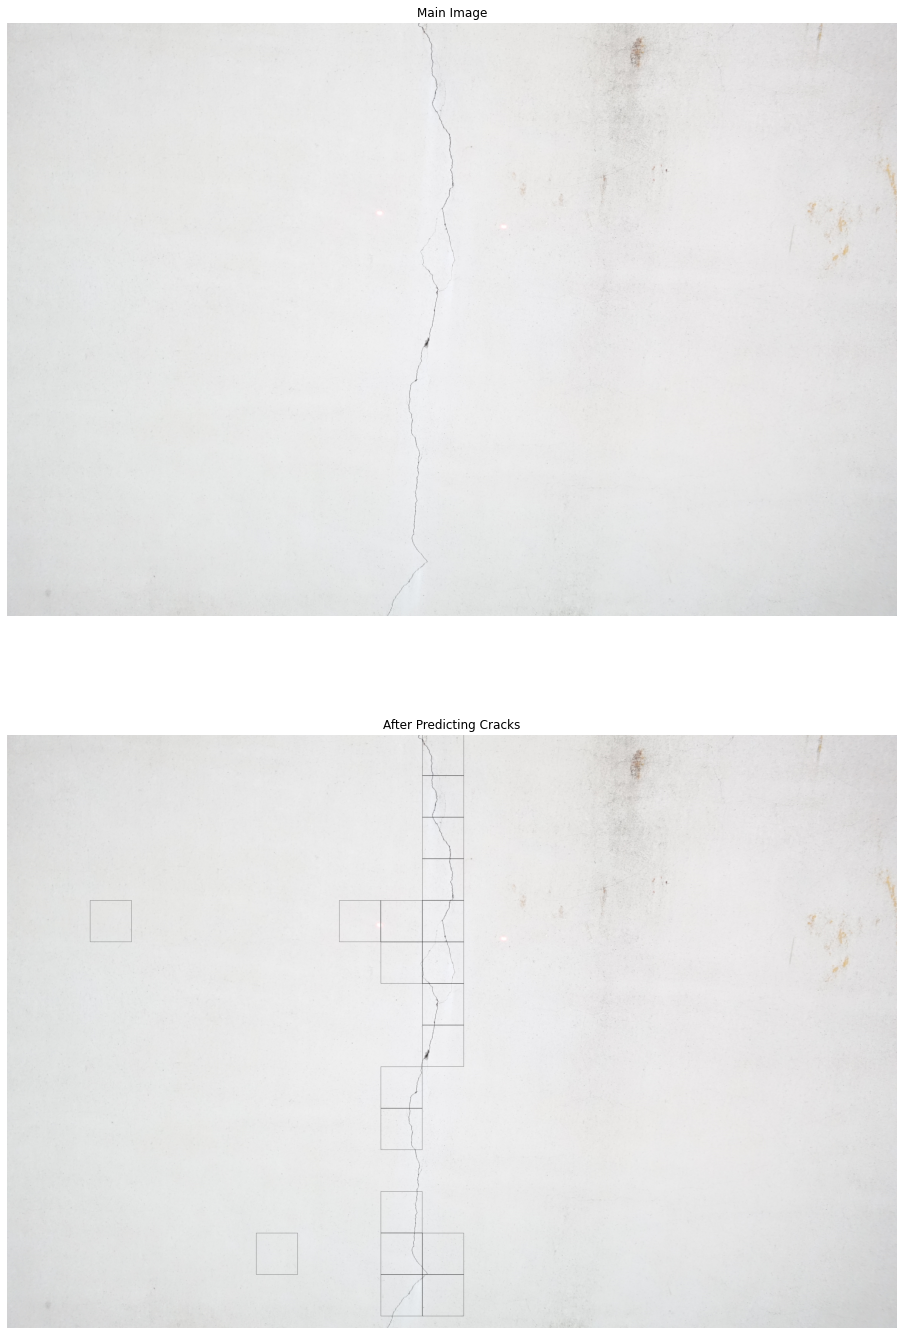

In [216]:
image = Image.open("/kaggle/input/surface-crack/predict/IMG_1130.JPG")
plt.figure(figsize = (32,24))
plt.subplot(2,1,1)
plt.imshow(image)
plt.title("Main Image")
plt.axis('off')

img_bound = bounding_box(np.asarray(image))

plt.subplot(2,1,2)
plt.imshow(img_bound)
plt.title("After Predicting Cracks")
plt.axis('off')

plt.show()

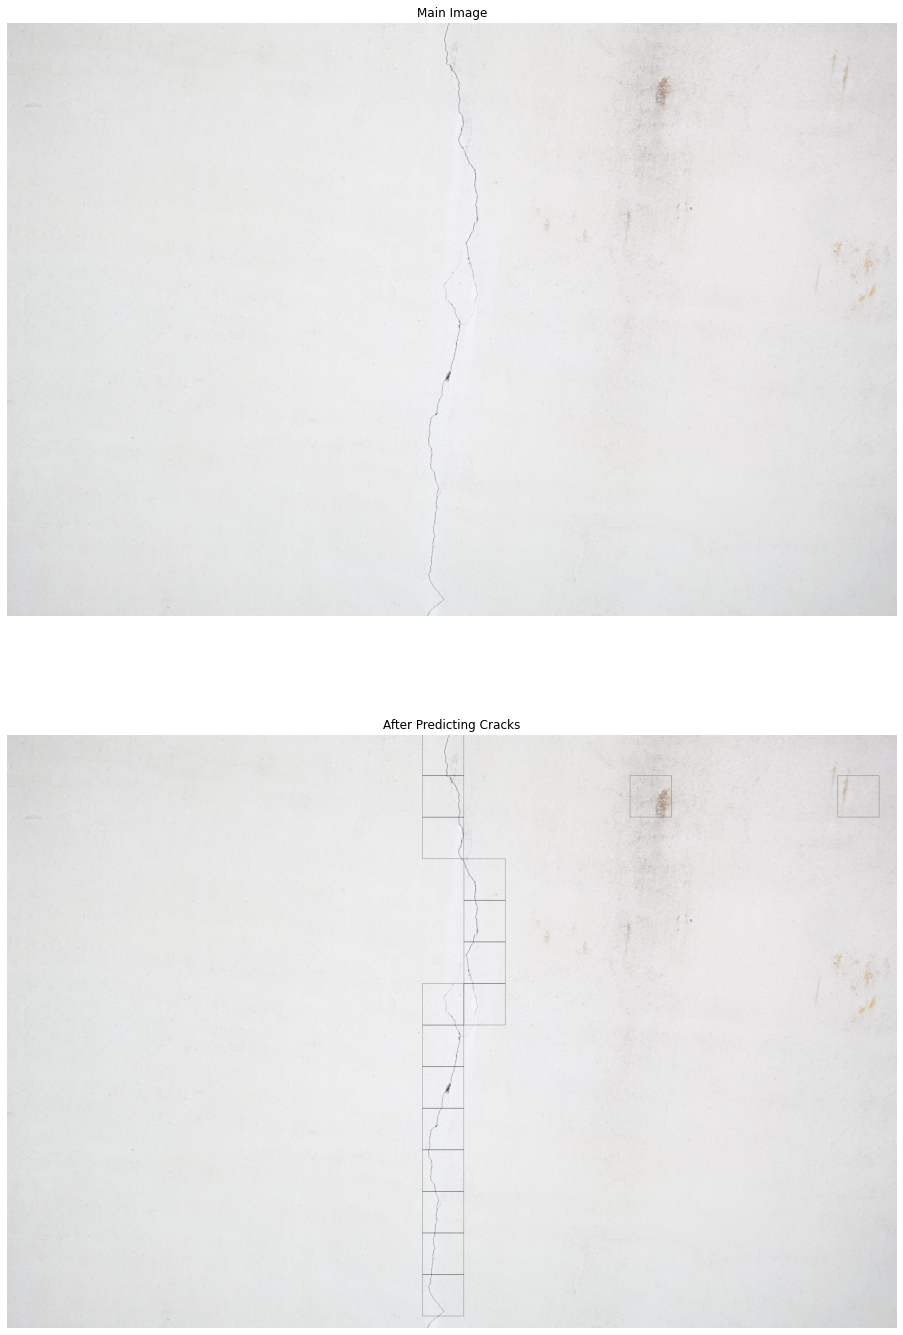

In [217]:
image = Image.open("/kaggle/input/surface-crack/predict/IMG_1131.JPG")
plt.figure(figsize = (32,24))
plt.subplot(2,1,1)
plt.imshow(image)
plt.title("Main Image")
plt.axis('off')

img_bound = bounding_box(np.asarray(image))

plt.subplot(2,1,2)
plt.imshow(img_bound)
plt.title("After Predicting Cracks")
plt.axis('off')

plt.show()

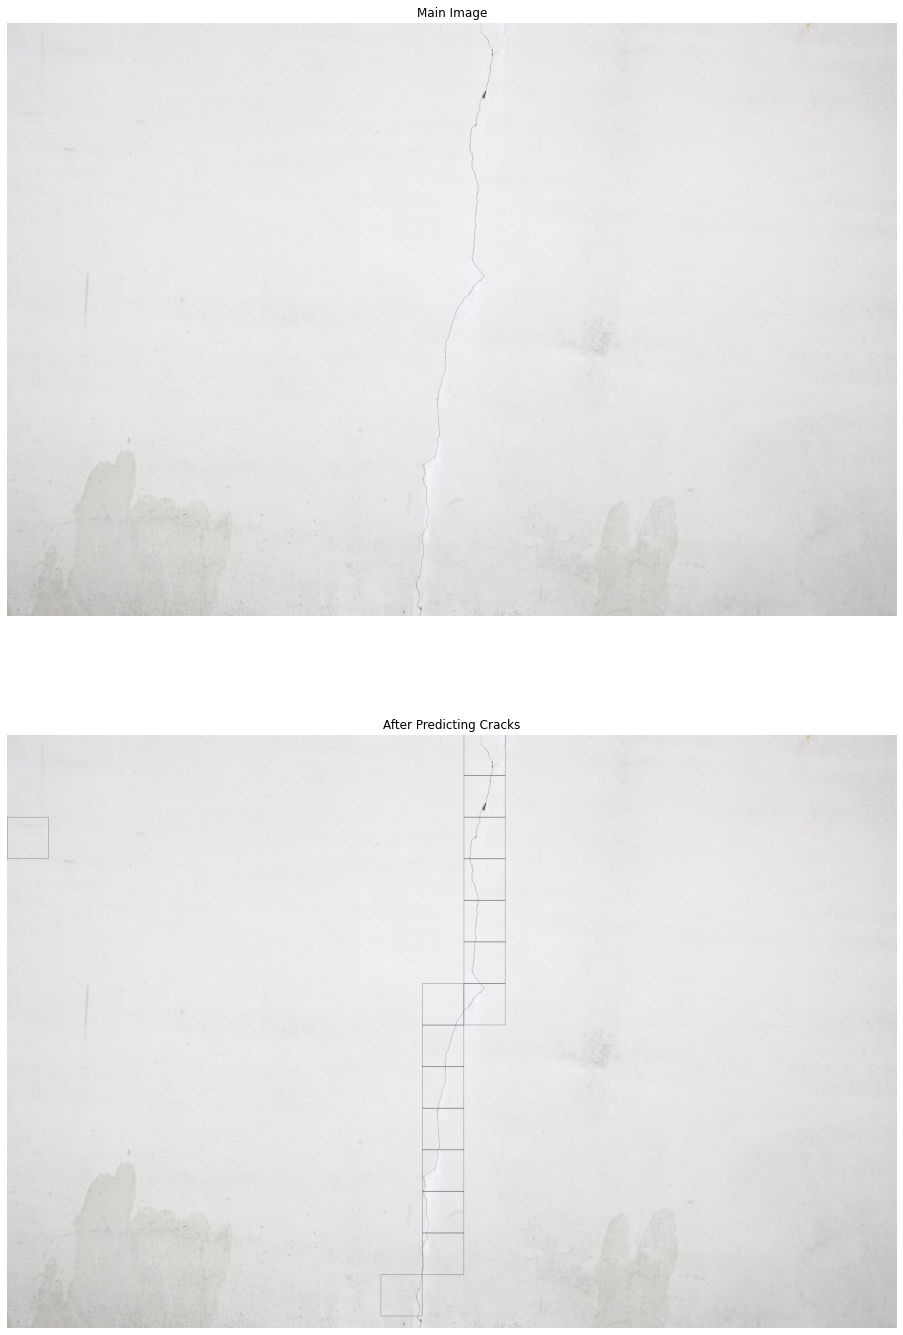

In [218]:
image = Image.open("/kaggle/input/surface-crack/predict/IMG_1132.JPG")
plt.figure(figsize = (32,24))
plt.subplot(2,1,1)
plt.imshow(image)
plt.title("Main Image")
plt.axis('off')

img_bound = bounding_box(np.asarray(image))

plt.subplot(2,1,2)
plt.imshow(img_bound)
plt.title("After Predicting Cracks")
plt.axis('off')

plt.show()

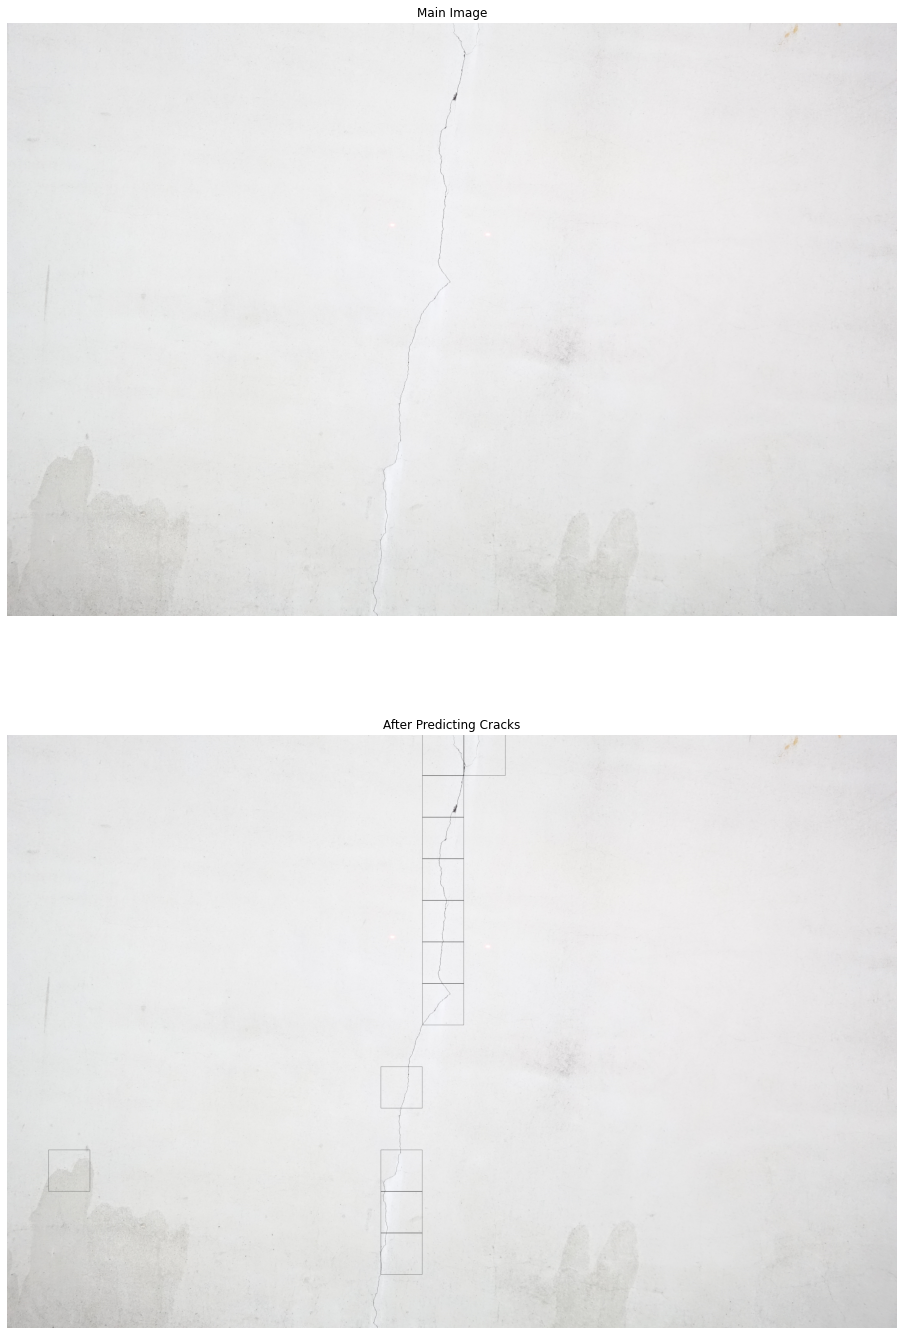

In [219]:
image = Image.open("/kaggle/input/surface-crack/predict/IMG_1133.JPG")
plt.figure(figsize = (32,24))
plt.subplot(2,1,1)
plt.imshow(image)
plt.title("Main Image")
plt.axis('off')

img_bound = bounding_box(np.asarray(image))

plt.subplot(2,1,2)
plt.imshow(img_bound)
plt.title("After Predicting Cracks")
plt.axis('off')

plt.show()

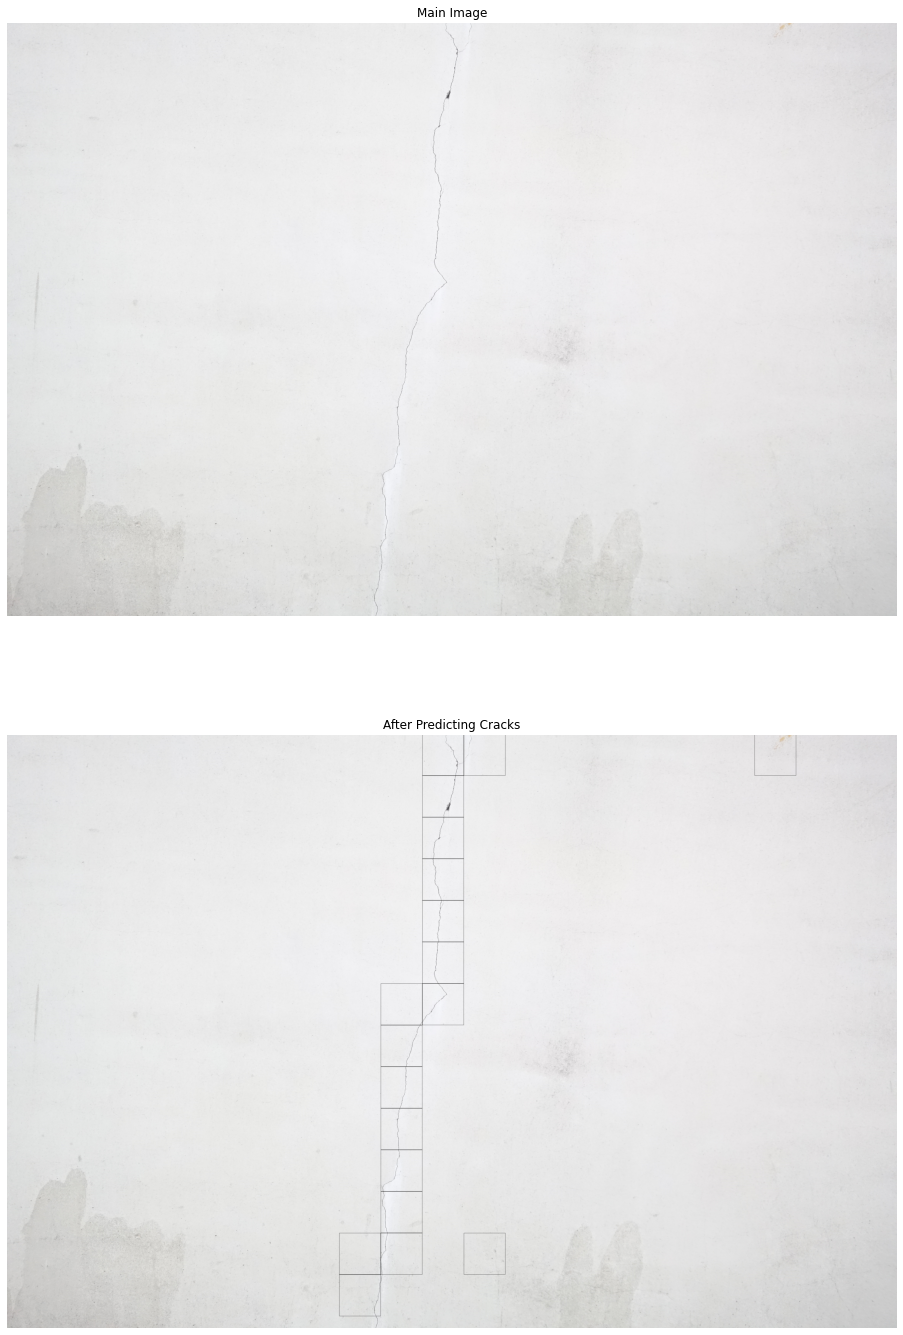

In [220]:
image = Image.open("/kaggle/input/surface-crack/predict/IMG_1134.JPG")
plt.figure(figsize = (32,24))
plt.subplot(2,1,1)
plt.imshow(image)
plt.title("Main Image")
plt.axis('off')

img_bound = bounding_box(np.asarray(image))

plt.subplot(2,1,2)
plt.imshow(img_bound)
plt.title("After Predicting Cracks")
plt.axis('off')

plt.show()

### As we saw that the model was performing well over higher dimensional images.

# Conclusions
### Decision Boundary for Classification = 0.65
### Metrics over Testing Data 
#### Accuracy = 97%
#### Precision = 94%
#### Recall = 100%
#### F1 Score = 96.9%